In [78]:
from silence_tensorflow import silence_tensorflow

silence_tensorflow()

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import shutil
from keras import layers
from tqdm import tqdm

# Train data preprocessing

Remove dublicate images from train dataset.

Add new feature "path" containing paths to the images.

Rename feature "damage" to "target".

Remove feature "filename"

In [80]:
def prepare_train_data(data, image_dir, RUN_COPY):
    df = data.copy()
    df = df.drop_duplicates(subset="filename", keep="first")
    df["target"] = df["damage"]
    df = df.drop(columns=["damage"])

    RUN_MOVE = False

    lst = []
    for row, (_, filename, target) in df.iterrows():
        destination = f"data/Classes/{target}"
        path = f"{image_dir}/{filename}"
        lst.append((row, f"{destination}/{filename}"))
        if RUN_MOVE:
            shutil.move(path, destination)
    for row, dest in lst:
        df.loc[row, "filename"] = dest
    df.rename(columns={"filename": "path"}, inplace=True)
    return df

In [81]:
train_data = prepare_train_data(pd.read_csv("data/Train.csv"), "images", False)
train_data

,ID,path,target
0,ID_UBHORS,data/Classes/WD/d036341be8d6cd59851cb80bcc9a70...,WD
1,ID_9DSOLZ,data/Classes/G/9ea16180c50d0cd539897eefbfe5853...,G
2,ID_JHLM0G,data/Classes/G/b6b564844041bc68774a553eaf43d61...,G
3,ID_ATREIJ,data/Classes/DR/62262859f0cd411aaf484082ed3ef0...,DR
4,ID_L2GAD6,data/Classes/G/03b6e2a8ace7cb611eccba289f3c83d...,G
...,...,...,...
26063,ID_SQQ5T2,data/Classes/DR/dd3f7966864f9466b9d57714983c32...,DR
26064,ID_T5WAM0,data/Classes/G/cab5d10958f28b17d887748f9cd1d35...,G
26065,ID_9W6G7O,data/Classes/G/7feedaf352fe16b24454fc4ee283bb8...,G
26066,ID_YQ07UW,data/Classes/G/f295f949ece1867921363df9e4c3d17...,G


# Test data preprocessing

In [82]:
def prepare_test_data(data, image_dir):
    df = data.copy()
    RUN_MOVE = False

    lst = []
    for row, (id, jpg) in df.iterrows():
        destination = f"data/Testdata"
        path = f"{image_dir}/{jpg}"
        lst.append((row, f"{destination}/{jpg}"))
        if RUN_MOVE:
            shutil.move(path, destination)
    for row, dest in lst:
        df.loc[row, "filename"] = dest
    df.rename(columns={"filename": "path"}, inplace=True)
    return df

In [83]:
test_data = prepare_test_data(pd.read_csv(f"data/Test.csv"), "images")
test_data

,ID,path
0,ID_QW9GQM,data/Testdata/03428805a0d7d269b422dbfafb3f86cb...
1,ID_G9VPQ9,data/Testdata/5dcf4f5d82708496ad7c3227ccbc8af5...
2,ID_QIMIEM,data/Testdata/4e835aa40e4aafa24db13cba4182094e...
3,ID_TSINUQ,data/Testdata/1e0dbb8669385be73a480ce108d12bdc...
4,ID_I7OOHH,data/Testdata/3d05e31502f9f00ce25770666c73af5f...
...,...,...
8658,ID_JZJP19,data/Testdata/8b58a11023be5530af0fd1800b2c53c3...
8659,ID_137G9B,data/Testdata/2d3c4c70b893bf32c33919e5c1703b81...
8660,ID_F7R60Y,data/Testdata/49d9c6cadb9a424fc31aff1d67320232...
8661,ID_76JGLU,data/Testdata/618f93ddbb02e2abf4b97ac458b2c2e7...


In [84]:
image_size = (256, 256)
batch_size = 64

train, val = keras.utils.image_dataset_from_directory(
    "data/Classes/",
    validation_split=0.2,
    subset="both",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    labels="inferred",
    label_mode="categorical",
)

Found 26068 files belonging to 5 classes.
Using 20855 files for training.
Using 5213 files for validation.


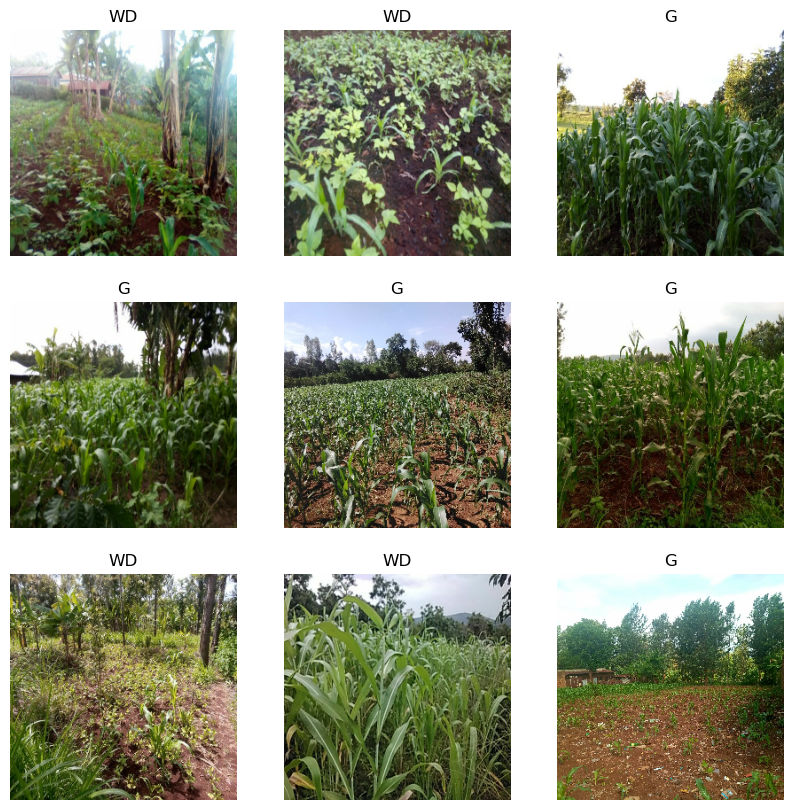

In [85]:
plt.figure(figsize=(10, 10))
class_names = train.class_names

for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

In [86]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

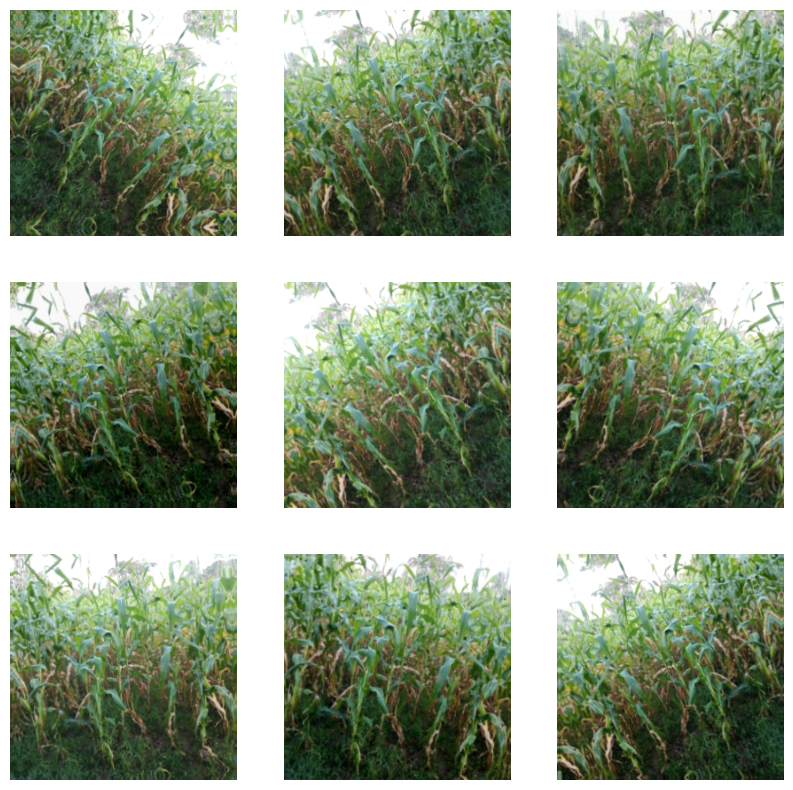

In [87]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [95]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16, 16, 16, 16, 16]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.2)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

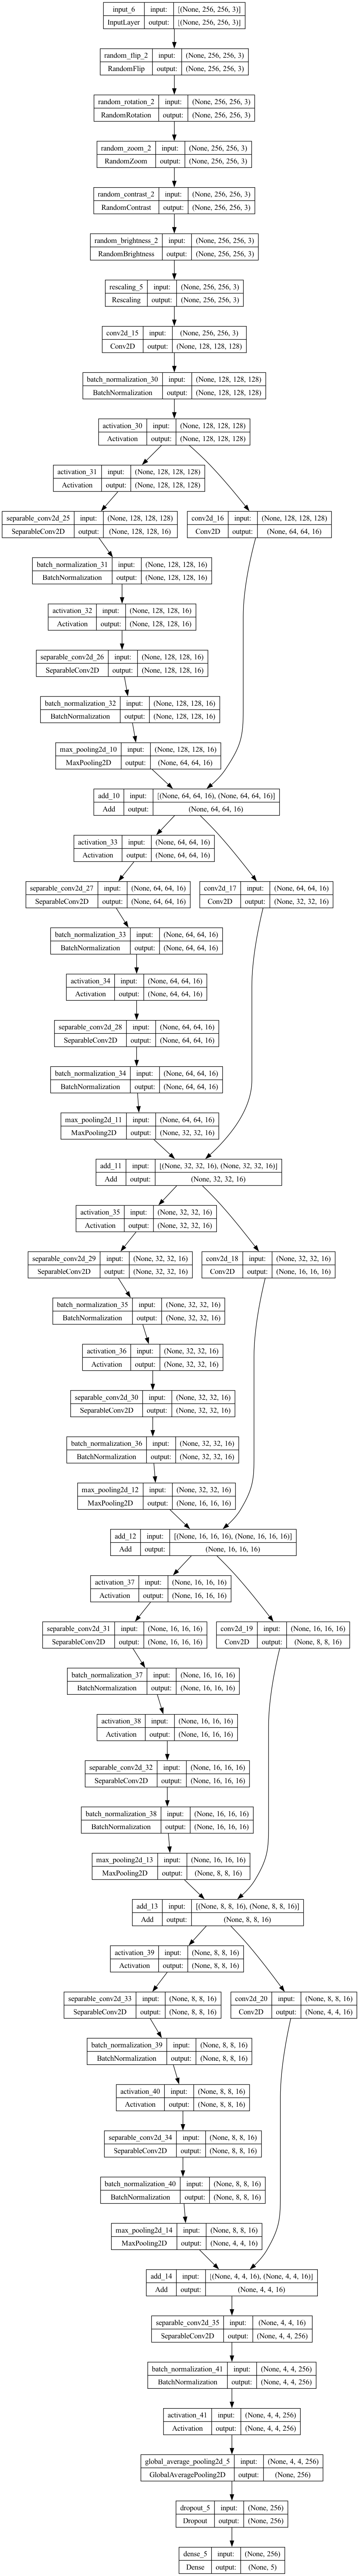

In [96]:
model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

In [97]:
epochs = 12

callbacks = [
    keras.callbacks.ModelCheckpoint("models/epoch_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.RMSprop(learning_rate=5e-2),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

history = model.fit(
    train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val,
    verbose=1,
)

Epoch 1/12
 80/326 [======>.......................] - ETA: 1:22 - loss: 15.6085 - accuracy: 0.3506

KeyboardInterrupt: 

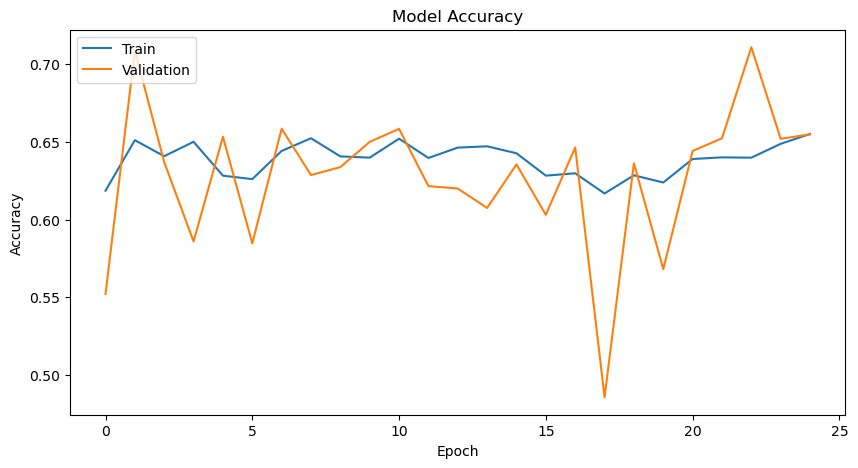

In [ ]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
loaded_model = keras.models.load_model("")

In [ ]:
class_labels = ["DR", "G", "ND", "WD", "other"]


submission_df = pd.DataFrame(0, columns=class_labels, index=test_data["ID"])

for row, (ID, path) in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    img = keras.utils.load_img(path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.backend.expand_dims(img_array, 0)
    predictions = loaded_model.predict(img_array, verbose=0)
    predictions_probabilities = [
        np.exp(logits) / np.sum(np.exp(logits)) for logits in predictions
    ]
    predicted_class_index = np.argmax(predictions_probabilities)
    submission_df.loc[ID, class_labels[predicted_class_index]] = 1.0

100%|██████████| 8663/8663 [06:02<00:00, 23.88it/s]


In [ ]:
submission_df.to_csv("submission.csv")

In [ ]:
submission_df.describe()

,DR,G,ND,WD,other
count,8663.000000,8663.000000,8663.0,8663.000000,8663.0
mean,0.940205,0.055985,0.0,0.003809,0.0
std,0.237119,0.229906,0.0,0.061605,0.0
min,0.000000,0.000000,0.0,0.000000,0.0
25%,1.000000,0.000000,0.0,0.000000,0.0
50%,1.000000,0.000000,0.0,0.000000,0.0
75%,1.000000,0.000000,0.0,0.000000,0.0
max,1.000000,1.000000,0.0,1.000000,0.0
